In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image
import random


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation,MaxPooling2D, Concatenate, AveragePooling2D, Lambda

from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination

C:\Users\jiayu\AppData\Local\Temp\ipykernel_17412\3945466512.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
SEED = 64

# SET RANDOM SEED FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Create variable to store dataset name
dataset_name = 'california_housing'
results_path = f'logs/{dataset_name}/ViT+MLP_Regression'

In [4]:
df = pd.read_csv(f"../Datasets_benchmark/{dataset_name}.csv")

LOAD AND PREPROCESS

In [5]:
from sklearn.preprocessing import MinMaxScaler
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type):

    # Generate the images if the folder does not exist
    if not os.path.exists(images_folder):
        #Generate thet images
        image_model.generateImages(df, images_folder)
    else:
        print("The images are already generated")

    img_paths = os.path.join(images_folder,problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, df], axis=1)

    # Split data
    df_x = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    df_y = combined_dataset["values"]

    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.40, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=SEED)

    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    imgs_shape = X_train_img[0].shape

    print("Images shape: ",imgs_shape)
    print("Attributres: ",attributes)
    pixels=X_train_img[0].shape[0]
    print("Image size (pixels):", pixels)

    return X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes

MODEL ARCHITECTURES

In [6]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
import tensorflow.keras.layers as nn

from tensorflow import einsum
from einops import rearrange, repeat
from einops.layers.tensorflow import Rearrange

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PreNorm(Layer):
    def __init__(self, fn):
        super(PreNorm, self).__init__()

        self.norm = nn.LayerNormalization()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(self.norm(x), training=training)

class MLP(Layer):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super(MLP, self).__init__()

        def GELU():
            def gelu(x, approximate=False):
                if approximate:
                    coeff = tf.cast(0.044715, x.dtype)
                    return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
                else:
                    return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

            return nn.Activation(gelu)

        self.net = Sequential([
            nn.Dense(units=hidden_dim),
            GELU(),
            nn.Dropout(rate=dropout),
            nn.Dense(units=dim),
            nn.Dropout(rate=dropout)
        ])

    def call(self, x, training=True):
        return self.net(x, training=training)

class Attention(Layer):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super(Attention, self).__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax()
        self.to_qkv = nn.Dense(units=inner_dim * 3, use_bias=False)

        if project_out:
            self.to_out = [
                nn.Dense(units=dim),
                nn.Dropout(rate=dropout)
            ]
        else:
            self.to_out = []

        self.to_out = Sequential(self.to_out)

    def call(self, x, training=True):
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        # dots = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2])) * self.scale
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = self.attend(dots)

        # x = tf.matmul(attn, v)
        x = einsum('b h i j, b h j d -> b h i d', attn, v)
        x = rearrange(x, 'b h n d -> b n (h d)')
        x = self.to_out(x, training=training)

        return x

class Transformer(Layer):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super(Transformer, self).__init__()

        self.layers = []

        for _ in range(depth):
            self.layers.append([
                PreNorm(Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(MLP(dim, mlp_dim, dropout=dropout))
            ])

    def call(self, x, training=True):
        for attn, mlp in self.layers:
            x = attn(x, training=training) + x
            x = mlp(x, training=training) + x

        return x

class ViT(Model):
    def __init__(self, image_size, patch_size, dim, depth, heads, mlp_dim,
                 pool='cls', dim_head=64, dropout=0.0, emb_dropout=0.0):
        """
            image_size: int.
            -> Image size. If you have rectangular images, make sure your image size is the maximum of the width and height
            patch_size: int.
            -> Number of patches. image_size must be divisible by patch_size.
            -> The number of patches is: n = (image_size // patch_size) ** 2 and n must be greater than 16.
            num_classes: int.
            -> Number of classes to classify.
            dim: int.
            -> Last dimension of output tensor after linear transformation nn.Linear(..., dim).
            depth: int.
            -> Number of Transformer blocks.
            heads: int.
            -> Number of heads in Multi-head Attention layer.
            mlp_dim: int.
            -> Dimension of the MLP (FeedForward) layer.
            dropout: float between [0, 1], default 0..
            -> Dropout rate.
            emb_dropout: float between [0, 1], default 0.
            -> Embedding dropout rate.
            pool: string, either cls token pooling or mean pooling
        """
        super(ViT, self).__init__()

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.patch_embedding = Sequential([
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Dense(units=dim)
        ], name='patch_embedding')

        self.pos_embedding = tf.Variable(initial_value=tf.random.normal([1, num_patches + 1, dim]))
        self.cls_token = tf.Variable(initial_value=tf.random.normal([1, 1, dim]))
        self.dropout = nn.Dropout(rate=emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool

    def call(self, img, training=True, **kwargs):
        x = self.patch_embedding(img)
        b, n, d = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = tf.concat([cls_tokens, x], axis=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x, training=training)

        x = self.transformer(x, training=training)

        if self.pool == 'mean':
            x = tf.reduce_mean(x, axis=1)
        else:
            x = x[:, 0]

        return x

In [7]:
# ViT + MLP

def create_model1(imgs_shape, attributes):
    # ViT branch
    vit_input = Input(shape=imgs_shape)

    vit_model = ViT(
        image_size = imgs_shape[0],
        patch_size = imgs_shape[0],
        dim = 64,
        depth = 2,
        heads = 4,
        mlp_dim = 128,
        dropout = 0.1,
        emb_dropout = 0.1
    )

    # Wrap the ViT model call in a Lambda layer
    vit_output = Lambda(lambda x: vit_model(x), output_shape=(64,))(vit_input)

    vit_output = Dense(32, activation='relu')(vit_output)
    vit_output = Dense(16, activation='relu')(vit_output)

    # MLP branch
    mlp_input = Input(shape=(attributes,))
    mlp_output = Dense(16, activation='relu')(mlp_input)
    mlp_output = Dense(32, activation='relu')(mlp_output)
    mlp_output = Dense(16, activation='relu')(mlp_output)

    # Concatenate the outputs of CNN and MLP branches
    concat_output = Concatenate()([vit_output, mlp_output])

    # Final MLP
    final_output = Dense(32, activation='relu')(concat_output)
    final_output = Dense(16, activation='relu')(final_output)
    final_output = Dense(8, activation='relu')(final_output)
    final_output = Dense(1)(final_output)  # Output layer for regression

    # Create the hybrid model
    model1 = Model(inputs=[mlp_input, vit_input], outputs=final_output)

    return model1

In [8]:
# ViT with patch size as divisor of image size
# ViT + MLP

def find_divisors(n):
    divisors = []
    for i in range(1, int(n**0.5) + 1):
        if n % i == 0:
            divisors.append(i)
            if i != n // i:  # Check to include both divisors if they are not the same
                divisors.append(n // i)
    divisors.sort()
    return divisors

def create_model2(imgs_shape, attributes):
    divisors = find_divisors(imgs_shape[0])
    
    vit_input = Input(shape=imgs_shape)

    vit_model = ViT(
        image_size = imgs_shape[0],
        patch_size = divisors[-2],
        dim = 64,
        depth = 2,
        heads = 4,
        mlp_dim = 128,
        dropout = 0.1,
        emb_dropout = 0.1
    )

    # Wrap the ViT model call in a Lambda layer
    vit_output = Lambda(lambda x: vit_model(x), output_shape=(64,))(vit_input)

    vit_output = Dense(64, activation='relu')(vit_output)
    vit_output = Dense(32, activation='relu')(vit_output)
    vit_output = Dense(16, activation='relu')(vit_output)

    # MLP branch
    mlp_input = Input(shape=(attributes,))
    mlp_output = Dense(16, activation='relu')(mlp_input)
    mlp_output = Dense(32, activation='relu')(mlp_output)
    mlp_output = Dense(16, activation='relu')(mlp_output)

    # Concatenate the outputs of CNN and MLP branches
    concat_output = Concatenate()([vit_output, mlp_output])

    # Final MLP
    final_output = Dense(32, activation='relu')(concat_output)
    final_output = Dense(16, activation='relu')(final_output)
    final_output = Dense(8, activation='relu')(final_output)
    final_output = Dense(1)(final_output)  # Output layer for regression

    # Create the hybrid model
    model2 = Model(inputs=[mlp_input, vit_input], outputs=final_output)

    return model2

METRICS

In [9]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

METRICS = [
    tf.keras.metrics.MeanSquaredError(name = 'mse'),
    tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
    tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
    r_square,
]

COMPILE AND FIT

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

def compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, model_name, batch_size=32, epochs=200, lr=1e-3):

    opt = Adam(learning_rate=lr)

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        min_delta=0.001,     # Minimum change in the monitored quantity to qualify as an improvement
        patience=20,          # Number of epochs with no improvement after which training will be stopped
        verbose=1,           # Print messages when the callback takes an action
        mode='min',           # Training will stop when the quantity monitored has stopped decreasing
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    
    model.compile(
        loss="mse",
        optimizer=opt,
        metrics=METRICS
    )

    model_history = model.fit(
        x=[X_train_num,X_train_img], y=y_train,
        validation_data=([X_val_num,X_val_img], y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

    os.makedirs(f"models/{dataset_name}/{model_name}", exist_ok=True)

    plt.figure()  # Start a new figure
    plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
    plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
    plt.legend(loc = 'upper right')
    plt.savefig(f"models/{dataset_name}/{model_name}/loss_plot.png")

    plt.figure()  # Start a new figure
    plt.plot(model_history.history['mse'], color = 'red', label = 'mse')
    plt.plot(model_history.history['val_mse'], color = 'green', label = 'val mse')
    plt.legend(loc = 'upper right')
    plt.savefig(f"models/{dataset_name}/{model_name}/mse_plot.png")

    # Save the model
    os.makedirs(f"models/{dataset_name}/{model_name}", exist_ok=True)
    model.save(f"models/{dataset_name}/{model_name}/model_{dataset_name}.keras")

    # Evaluate the model on the training set
    train_scores = model.evaluate([X_train_num,X_train_img], y_train)

    # Evaluate the model on the validation set
    val_scores = model.evaluate([X_val_num,X_val_img], y_val)

    # Evaluate the model on the test set
    score_test = model.evaluate([X_test_num,X_test_img], y_test)

    # Save training, validation, and test scores
    metrics = {
        'train_loss': train_scores[0],
        'train_mse': train_scores[1],
        'train_mae': train_scores[2],
        'train_rmse': train_scores[3],
        'train_r2': train_scores[4],
        'val_loss': val_scores[0],
        'val_mse': val_scores[1],
        'val_mae': val_scores[2],
        'val_rmse': val_scores[3],
        'val_r2': val_scores[4],
        'test_loss': score_test[0],
        'test_mse': score_test[1],
        'test_mae': score_test[2],
        'test_rmse': score_test[3],
        'test_r2': score_test[4]
    }

    # Save metrics to a file
    os.makedirs(f'{results_path}/{model_name}', exist_ok=True)
    with open(f'{results_path}/{model_name}/{dataset_name}_metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')

    return metrics

In [11]:
def safe_compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test,dataset_name, model_name, batch_size=32, epochs=200, lr=1e-3):
    try:
        metrics = compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test,dataset_name, model_name, batch_size, epochs, lr)
        return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None

TEST

In [12]:
#Select the model and the parameters
problem_type = "regression"
#image_model = REFINED(problem= problem_type,hcIterations=5)
image_model = TINTO(problem= problem_type, blur=True)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_IGTD"

In [13]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[3,3])

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_IGTD"

In [14]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

The images are already generated
../HyNNImages/Regression/california_housing/images_california_housing_IGTD\regression.csv


Images shape:  (3, 3, 3)
Attributres:  8
Image size (pixels): 3


In [15]:
model1 = create_model1(imgs_shape, attributes)
model2 = create_model2(imgs_shape, attributes)
#model3 = create_model3(imgs_shape)

Epoch 1/200


387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4596 - mae: 0.4879 - mse: 0.4701 - r_square: 0.6423 - rmse: 0.6856 - val_loss: 0.4848 - val_mae: 0.4935 - val_mse: 0.4848 - val_r_square: 0.6298 - val_rmse: 0.6963
Epoch 2/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4509 - mae: 0.4799 - mse: 0.4509 - r_square: 0.6489 - rmse: 0.6714 - val_loss: 0.4757 - val_mae: 0.4846 - val_mse: 0.4757 - val_r_square: 0.6368 - val_rmse: 0.6897
Epoch 3/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4430 - mae: 0.4769 - mse: 0.4430 - r_square: 0.6554 - rmse: 0.6655 - val_loss: 0.4576 - val_mae: 0.4836 - val_mse: 0.4576 - val_r_square: 0.6490 - val_rmse: 0.6765
Epoch 4/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4347 - mae: 0.4718 - mse: 0.4347 - r_square: 0.6614 - rmse: 0.6592 - val_loss: 0.4509 - val_mae: 0.4814 - val_mse: 0.4509 - val_r_square: 0.6542 - val_rmse: 0.6715
Epoch 5/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4289 - mae: 0.4682 - mse: 0.4289 - r_squa

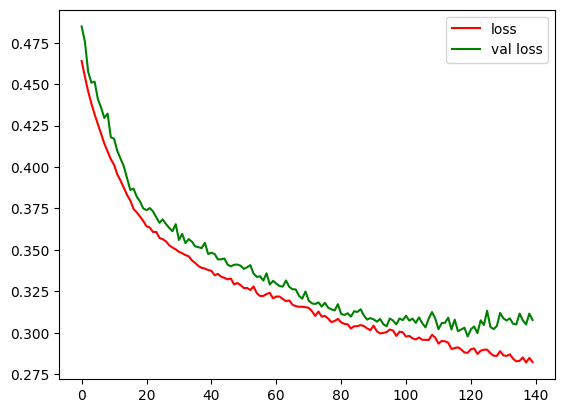

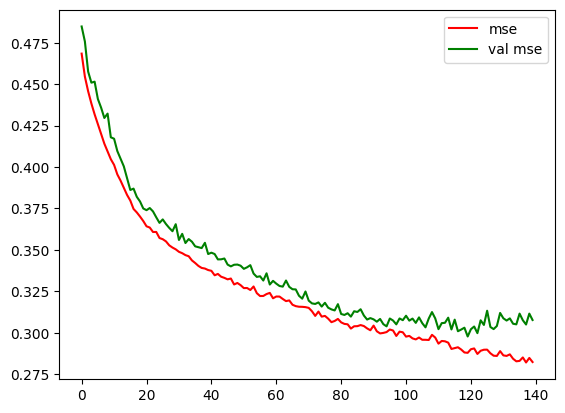

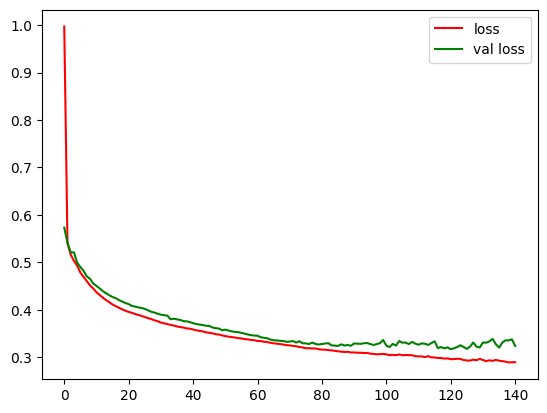

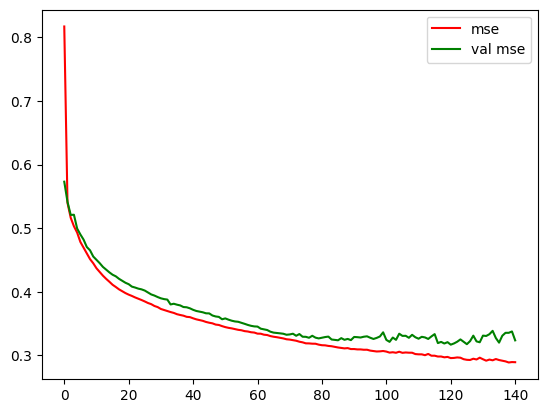

In [17]:
# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, "IGTD_model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, "IGTD_Model2")
#model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, "TINTO_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
#if model3_metrics:
#    print("Model 3 Metrics:", model3_metrics)

In [18]:
def find_best_model(base_path):
    best_rmse = float('inf')
    best_folder = None

    # Walk through all directories and files in the base path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f'{dataset_name}_metrics.txt':
                file_path = os.path.join(root, file)
                
                # Read metrics from the file
                with open(file_path, 'r') as f:
                    metrics = f.read()
                
                # Parse the metrics into a dictionary
                metrics_dict = {}
                for line in metrics.splitlines():
                    key, value = line.split(': ')
                    metrics_dict[key.strip()] = float(value.strip())
                
                # Check if the current folder has a better validation loss
                if metrics_dict['test_rmse'] < best_rmse:
                    best_rmse = metrics_dict['test_rmse']
                    best_folder = root
    
    return best_folder, best_rmse

In [19]:
import os

def rename_folder(old_folder_path):
    # Extract the base name of the old folder
    folder_name = os.path.basename(old_folder_path)
    
    # Create the new folder name by prepending "best_"
    new_folder_name = f"BEST_{folder_name}"
    
    # Get the parent directory of the old folder
    parent_dir = os.path.dirname(old_folder_path)
    
    # Create the full path for the new folder
    new_folder_path = os.path.join(parent_dir, new_folder_name)
    
    # Rename the folder
    os.rename(old_folder_path, new_folder_path)
    
    return new_folder_path

In [20]:
# Usage
base_path = f"logs/{dataset_name}/ViT+MLP_Regression"
best_folder, best_rmse = find_best_model(base_path)
best_folder = rename_folder(best_folder)
print(f"Best model folder: {best_folder}")
print(f"Best RMSE: {best_rmse}")

Best model folder: logs/california_housing/ViT+MLP_Regression\BEST_IGTD_model1
Best RMSE: 0.5258251428604126
